In [1]:
import sys
sys.path.append("../../../../src")
import nanonets
import nanonets_utils
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import scienceplots
import numpy as np

from tqdm import tqdm
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

%matplotlib inline

plt.style.use(["science","bright","grid"])

def exponential_decay(t, tau, a0):
    return a0 + (1 - a0) * np.exp(-t / tau)

def double_exponential(t, tau1, tau2, A1, A2, a0):
    return a0 + A1 * np.exp(-t / tau1) + A2 * np.exp(-t / tau2)

In [60]:
N_p                 = 9
topology_parameter  = {
    "Nx"                : N_p,
    "Ny"                : N_p,
    "Nz"                : 1,
    "e_pos"             : [[(N_p-1)//2,0,0],[0,0,0],[N_p-1,0,0],[0,(N_p-1)//2,0],
                        [N_p-1,(N_p-1)//2,0],[0,N_p-1,0],[N_p-1,N_p-1,0],[(N_p-1)//2,N_p-1,0]],
    "electrode_type"    : ['constant','constant','constant','constant','constant','constant','constant','constant']
}
sim_dic =   {
    "error_th"        : 0.0,
    "max_jumps"       : 1000,
    "eq_steps"        : 100000,
    "jumps_per_batch" : 1,
    "kmc_counting"    : False,
    "min_batches"     : np.inf
}

In [61]:
N_voltages  = 100
voltages    = np.random.uniform(-0.1,0.1,size=(N_voltages,len(topology_parameter["e_pos"])))
voltages    = np.hstack((voltages,np.zeros(N_voltages)[:,np.newaxis]))

In [62]:
sim_class   = nanonets.simulation(topology_parameter=topology_parameter)
sim_class.run_const_voltages(voltages=voltages,target_electrode=7, save_th=0.1, verbose=True, sim_dic=sim_dic, T_val=0.28)

Text(0.5, 0, '$\\overline{t_{KMC}}$ [ps]')

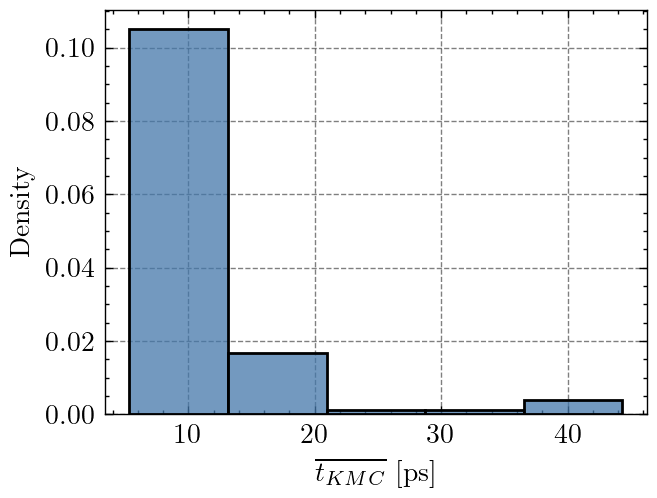

In [66]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax  = sns.histplot(np.mean(sim_class.time_values,axis=1)*1e12, bins=5, stat='density', ax=ax)
ax.set_xlabel("$\\overline{t_{KMC}}$ [ps]")

In [209]:
n_lags  = 50
results = []

for i in tqdm(range(N_voltages)):
    t       = np.cumsum(sim_class.time_values[i])
    t       = np.insert(t, 0, 0)
    corrs   = []
    for j in range(N_p*N_p):
        arr     = sim_class.pot_per_it[i][:,j+8]
        t_c     = t[:n_lags]
        a_c     = np.array(nanonets_utils.autocorrelation(arr, arr, n_lags))
        p, _    = curve_fit(exponential_decay, t_c, a_c, p0=[2e-10, 0.2])
        corrs.append(p[0])
    results.append(corrs)

 60%|██████    | 60/100 [00:18<00:11,  3.50it/s]/home/jonasmensing/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
100%|██████████| 100/100 [00:30<00:00,  3.33it/s]


In [212]:
df_results  = pd.DataFrame(results)*1e9
res_flatten = np.array(results).flatten()*1e9
df_results

,0,1,2,3,4,5,6,7,8,9,...,111,112,113,114,115,116,117,118,119,120
0,1.182666,0.238730,0.386782,1.052252,0.383485,0.048103,0.154651,0.422354,0.677520,5.783534,...,0.349872,5365.099228,1533.273190,1.036723,0.187053,0.278618,0.959210,0.829303,1.022716,0.052973
1,0.444174,0.619527,0.730861,32.966120,17.819604,0.442295,0.617661,7407.058950,1.047762,0.929496,...,9169.530904,5340.456928,2988.340906,1.121021,0.236805,4.345759,7924.543808,26040.230233,1.250047,0.337165
2,0.163701,0.260716,0.308603,0.264559,0.297417,0.182191,0.980180,0.493206,0.689404,1.020712,...,0.575795,0.378699,1.491208,0.539013,0.280924,0.497602,0.352723,0.658453,0.358307,2.423529
3,0.163807,0.298888,0.399337,0.555706,0.212989,0.243744,0.440523,9935.276323,0.549120,0.153975,...,3277.148470,7917.189196,0.627697,0.701822,0.184853,2.682389,13170.990709,1.273940,0.144886,0.194444
4,0.250402,0.812843,7.080778,1.673137,3849.672534,0.674636,1689.062854,4162.675533,0.461179,0.646019,...,0.702984,4560.886268,10973.212119,4350.840427,3.825616,14670.765721,8526.488227,3047.727140,7680.397481,0.390502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.463401,6.666101,3.758321,2.860526,0.475534,0.365082,0.539474,5677.264237,0.461147,0.585174,...,1.108421,0.552830,0.766511,0.692911,0.117613,0.156021,0.221103,0.377994,0.395909,0.125889
96,0.095667,0.181725,0.170821,0.179243,0.139199,0.090123,3.842218,0.276601,7493.464780,2566.142271,...,2.019134,2.123488,15083.244855,0.289219,0.364865,1.965343,1727.882389,3.489839,0.873747,0.143029
97,0.619367,17679.003086,7112.471497,17243.772504,2.606998,0.264333,0.272533,1.033907,0.427630,1.490226,...,0.382043,0.547526,0.554836,1.232326,0.321960,3.426494,18850.328194,11.769692,2.607637,1.780646
98,0.609955,3778.974400,9421.774615,5227.619898,12683.236927,3.173211,4273.232385,5583.924938,13720.669298,5416.807271,...,0.787635,0.477489,2033.175107,0.228052,0.360623,8976.816033,4088.278143,7046.230191,4.779403,0.748205


In [ ]:
arr = sim_class.return_pot_per_it()[98][:,8+1]


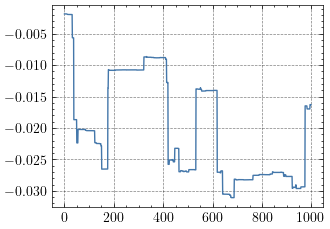

In [214]:
plt.plot(sim_class.return_pot_per_it()[98][:,8+1])

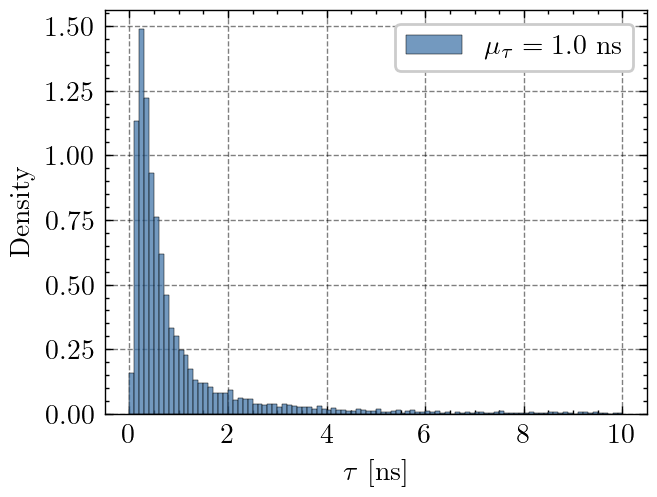

In [215]:
max_tau     = 10
mean_tau    = np.round(np.mean(res_flatten[res_flatten<max_tau]),2)

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax  = sns.histplot(res_flatten, bins=100, binrange=(0,max_tau), stat='density', ax=ax, label='$\mu_{\\tau} = '+f'{mean_tau}$ ns')
ax.set_xlabel("$\\tau$ [ns]")
ax.legend()

fig.savefig("../plots/time_constant.svg", transparent=True)
fig.savefig("../plots/time_constant.pdf", transparent=False)

In [225]:
# np_info2 = {
#     'np_index'      : [(i+1)*N_p*N_p//8 for i in range(7)],
#     'mean_radius'   : 100.0,
#     'std_radius'    : 0.0
# }
np_info = {
    "eps_r"         : 2.6,  # Permittivity of molecular junction 
    "eps_s"         : 3.9,  # Permittivity of oxide layer
    "mean_radius"   : 100.0, # average nanoparticle radius
    "std_radius"    : 0.0,  # standard deviation of nanoparticle radius
    "np_distance"   : 1.0   # spacing between nanoparticle shells
}

In [226]:
sim_class_dis   = nanonets.simulation(topology_parameter=topology_parameter, np_info=np_info) #np_info2=np_info2)
sim_class_dis.run_const_voltages(voltages=voltages,target_electrode=7, save_th=0.1, verbose=True, sim_dic=sim_dic)

In [227]:
n_lags      = 500
results_dis = []

for i in tqdm(range(N_voltages)):
    t       = np.cumsum(sim_class_dis.time_values[i])
    t       = np.insert(t, 0, 0)
    corrs   = []
    for j in range(N_p*N_p):
        arr     = sim_class_dis.pot_per_it[i][:,j+8]
        t_c     = t[:n_lags]
        a_c     = np.array(nanonets_utils.autocorrelation(arr, arr, n_lags))
        p, _    = curve_fit(exponential_decay, t_c, a_c, p0=[2e-10, 0.2])
        corrs.append(p[0])
    results_dis.append(corrs)

 16%|█▌        | 16/100 [00:40<03:33,  2.54s/it]/tmp/ipykernel_24660/2260909395.py:21: RuntimeWarning: overflow encountered in exp
  return a0 + (1 - a0) * np.exp(-t / tau)
100%|██████████| 100/100 [04:03<00:00,  2.44s/it]


In [228]:
df_results_dis  = pd.DataFrame(results_dis)*1e9
res_flatten_dis = np.array(results_dis).flatten()*1e9
df_results_dis

,0,1,2,3,4,5,6,7,8,9,...,111,112,113,114,115,116,117,118,119,120
0,24815.916635,182582.113453,78340.752922,4.214246,0.915339,0.705237,1.424045,22834.931962,51719.762289,0.545122,...,54645.792392,0.918488,0.724413,1.978692,0.522884,0.755656,0.814818,0.816703,0.871706,1.612377
1,2.164995,0.891474,60.905235,31543.720004,20657.436347,80230.314424,2.555289,6811.195123,2.192846,2.674240,...,123640.327922,56340.344008,1.380296,42795.079459,0.410472,1.104948,1.135045,0.955304,2.790894,4.803073
2,1.422172,44208.340927,0.314270,0.554237,0.974616,0.433237,1.103441,0.426866,0.940563,2.489505,...,0.659091,0.372310,0.932949,42486.868129,130767.639007,142973.590057,5.551419,26265.283601,4.763854,0.351785
3,0.746862,0.711879,1.165270,0.553486,0.472831,0.712656,2.860437,2.052188,0.815889,2.664960,...,1.629246,1.004645,0.753702,176338.164493,1.219088,0.679679,99951.407412,84576.028647,39433.445976,175696.952616
4,0.676143,44479.852118,30614.145883,0.306564,0.617390,1.256196,0.934885,73780.294121,34080.859964,1.027140,...,1.383667,0.765276,1.270341,2.168500,0.701021,37792.051557,0.592280,3.388967,1.212547,0.646905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,74494.646265,88530.049690,1.064704,1.606956,1.281839,0.542760,214157.753251,5.289055,62032.909886,0.607968,...,52767.069923,79917.368025,4.523874,1.398666,0.509778,106276.387607,0.579838,13696.575123,52390.829129,2.849913
96,18.546014,167606.772840,52054.783402,0.798346,95660.025248,4.179601,66418.319169,0.687841,1.101239,0.678650,...,3.615202,6.471331,1.313256,21.512572,0.887335,95459.625563,1.375923,7.403220,2.416905,2.125726
97,0.740490,1.519076,23698.267465,1.681479,0.948419,64937.719402,66524.688667,117466.429356,173106.459621,0.455822,...,105077.819737,0.936515,4.426390,1.125134,0.814441,0.934706,32555.668201,51863.901906,94089.881523,0.833161
98,1.005274,2.780127,0.630040,0.560994,1.683910,0.620595,18.418505,0.304179,2.226126,12.005439,...,0.887580,78607.818203,0.507217,0.545037,13.760868,2805.276091,1.405501,28207.457624,64655.966373,49360.236940


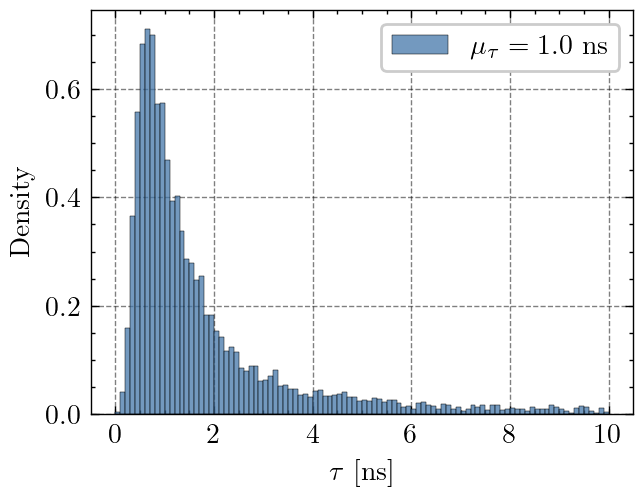

In [229]:
max_tau     = 10
mean_tau    = np.round(np.mean(res_flatten[res_flatten<max_tau]),2)

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax  = sns.histplot(res_flatten_dis, bins=100, binrange=(0,max_tau), stat='density', ax=ax, label='$\mu_{\\tau} = '+f'{mean_tau}$ ns')
ax.set_xlabel("$\\tau$ [ns]")
ax.legend()

fig.savefig("../plots/time_constant_dis.svg", transparent=True)
fig.savefig("../plots/time_constant_dis.pdf", transparent=False)

In [230]:
res_info2 = {
    'np_index'      : [(i+1)*N_p*N_p//8 for i in range(7)],
    'R'             : 250.0,
}

res_info = {
    "mean_R"    : 250.0, # Average resistance
    "std_R"     : 0.0,  # Standard deviation of resistances
    "dynamic"   : False # Dynamic or constant resistances
}

In [231]:
sim_class_dis_R   = nanonets.simulation(topology_parameter=topology_parameter, res_info=res_info)#res_info2=res_info2)
sim_class_dis_R.run_const_voltages(voltages=voltages,target_electrode=7, save_th=0.1, verbose=True, sim_dic=sim_dic)

In [232]:
n_lags          = 500
results_dis_R   = []

for i in tqdm(range(N_voltages)):
    t       = np.cumsum(sim_class_dis_R.time_values[i])
    t       = np.insert(t, 0, 0)
    corrs   = []
    for j in range(N_p*N_p):
        arr     = sim_class_dis_R.pot_per_it[i][:,j+8]
        t_c     = t[:n_lags]
        a_c     = np.array(nanonets_utils.autocorrelation(arr, arr, n_lags))
        p, _    = curve_fit(exponential_decay, t_c, a_c, p0=[2e-10, 0.2])
        corrs.append(p[0])
    results_dis_R.append(corrs)

100%|██████████| 100/100 [03:54<00:00,  2.34s/it]


In [233]:
df_results_dis_R    = pd.DataFrame(results_dis_R)*1e9
res_flatten_dis_R   = np.array(results_dis_R).flatten()*1e9
df_results_dis_R

,0,1,2,3,4,5,6,7,8,9,...,111,112,113,114,115,116,117,118,119,120
0,36.614615,1.917406,2.467526,1.910747,0.825702,0.632669,2.268122,2.272937,8.615643e+00,9.263880,...,5.155130,10.030451,1.367184e+06,73.659784,2.757912,3.790612,4.173033,7.407773,43.558551,6.281208
1,1.666611,2.079050,6.066423,9.954178,2.063113,1.983046,2.899324,4.372791,1.983192e+01,2.503022,...,2.526279,4.303138,1.082496e+01,3.788084,2.401985,16.614601,14.073526,3.441462,2.228872,1.402367
2,1.999814,5.656420,2.682176,7.935435,3.066964,1.346116,3.054197,4.198151,4.305349e+00,1.964776,...,1.989908,3.084548,1.562557e+01,2.425521,1.278279,9.126207,12.869103,12.500584,3.633299,27.916329
3,1.813503,1.436176,3.737081,3.335657,6.223818,1.476153,3.480413,18.199455,2.540404e+06,20.941663,...,332.984571,15.651764,3.595895e+01,44.165233,8.144537,27.502642,13.631146,9.364906,5.305757,3.343374
4,7.151428,6.710348,8.093744,72.006846,9.824469,5.112468,7.910332,4.236355,3.750695e+00,2.852822,...,2.588756,2.656785,3.933915e+00,18.170553,33.522000,42.658460,9.046180,16.599129,14.011659,3.459348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.705910,2.592113,2.794472,2.186284,2.975552,2.253819,3.455475,2.881326,2.399750e+00,3.315154,...,6.629403,2.378999,7.339650e+00,6.712542,2.201440,1.398510,3.044115,4.474059,3.268408,5.185140
96,3.205907,2.243193,1.318485,1.977852,1.708833,1.269653,2.757430,10.067039,5.414348e+00,2.066778,...,7.548145,12.282395,5.311758e+00,3.187961,21.915297,34.371457,37.283853,9.558403,9.848107,2.948300
97,2.792113,5.734171,11.520510,7.637918,4.697380,3.120601,5.082989,8.460689,3.708561e+00,4.195999,...,4.292535,5.555700,7.611861e+00,10.413788,7.308624,7.271095,3.487351,14.723401,7.465943,4.374252
98,1.263944,4.901248,116.758236,13.261141,5.972078,6.962189,22.512065,14.463887,5.745899e+00,14.087182,...,2.638754,1.959975,2.082017e+00,1.496355,1.688207,4.791459,5.030328,5.616718,3.450616,2.135790


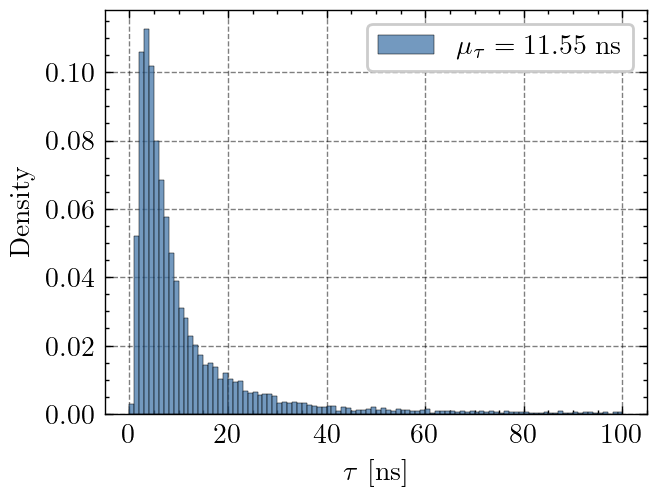

In [237]:
max_tau     = 100
mean_tau    = np.round(np.mean(res_flatten_dis_R[res_flatten_dis_R<max_tau]),2)

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax  = sns.histplot(res_flatten_dis_R, bins=100, binrange=(0,max_tau), stat='density', ax=ax, label='$\mu_{\\tau} = '+f'{mean_tau}$ ns')
ax.set_xlabel("$\\tau$ [ns]")
ax.legend()

fig.savefig("../plots/time_constant_dis_R.svg", transparent=True)
fig.savefig("../plots/time_constant_dis_R.pdf", transparent=False)